purpose: run validation analysis on RGD data using the mammalian phenotype ontology

# set-up

In [1]:
# load required libraries
import pandas as pd
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
import mygene
mg = mygene.MyGeneInfo()
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import obonet as obo
import networkx as nx
import requests
import scipy.stats as stats
import numpy as np
from adjustText import adjust_text
import matplotlib.patches as mpatches
import os
os.chdir('/tscc/projects/ps-palmer/brittany/ddot')
import ddot
from netcoloc import netprop_zscore, netprop, network_colocalization, validation
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks')
from rca_functions import import_seedgenes, import_interactome
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [3]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [4]:
interactome_name='PCNet2.0'

In [5]:
interactome=import_interactome(UUIDs=UUIDs, interactome_name=interactome_name)
all_nodes=list(interactome.nodes())

PCNet2.0
number of nodes:
19267

number of edges:
3852119


# import NPS scores and seed genes

In [6]:
seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,all_nodes)
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR'])

In [7]:
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
for t in ctrl_traits:
    seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
    seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
    seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [8]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,UUIDs)
NPS_dict.keys()

dict_keys(['loco_bonf_PCNet2.0', 'loco_bonf_PCNet2.2', 'loco_FDR_PCNet2.0', 'loco_FDR_PCNet2.2', 'loco_gsem_bonf_PCNet2.0', 'loco_gsem_bonf_PCNet2.1', 'loco_gsem_bonf_PCNet2.2', 'loco_gsem_FDR_PCNet2.0', 'loco_gsem_FDR_PCNet2.1', 'loco_gsem_FDR_PCNet2.2', 'ext_bonf_PCNet2.0', 'ext_bonf_PCNet2.2', 'ext_top500_PCNet2.0', 'ext_top500_PCNet2.2', 'ext_FDR_PCNet2.0', 'ext_FDR_PCNet2.2', 'ext_st22_PCNet2.0', 'ext_st22_PCNet2.2', 'loco_mega_fus_naac_bonf_PCNet2.0', 'loco_mega_fus_naac_bonf_PCNet2.2', 'loco_mega_fus_naac_FDR_PCNet2.0', 'loco_mega_fus_naac_FDR_PCNet2.2', 'ext_fus_naac_bonf_PCNet2.0', 'ext_fus_naac_bonf_PCNet2.2', 'ext_fus_naac_top500_PCNet2.0', 'ext_fus_naac_top500_PCNet2.2', 'ext_fus_naac_FDR_PCNet2.0', 'ext_fus_naac_FDR_PCNet2.2', 'facial_hair_FDR_PCNet2.0', 'facial_hair_FDR_PCNet2.2', 'facial_hair_bonf_PCNet2.0', 'facial_hair_bonf_PCNet2.2', 'facial_hair_top500_PCNet2.0', 'facial_hair_top500_PCNet2.2', 'age_smkinit_FDR_PCNet2.0', 'age_smkinit_FDR_PCNet2.2', 'age_smkinit_bonf_

# import RGD datasets

In [9]:
rgd_df=pd.read_csv('validation_datasets/rattus_genes_mp.tsv',sep='\t',skiprows=5,header=None)
rgd_df.columns=['DB',
'DB_Object_ID',
'DB_Object_Symbol',
'Qualifier',
'MP_ID',
'DB:Reference_(|DB:Reference)',
'Evidence_Code',
'With_(or)_From',
'Aspect',
'DB_Object_Name',
'DB_Object_Synonym_(|Synonym)',
'DB_Object_Type',
'Taxon(|taxon)',
'Date',
'Assigned_By',
'Annotation_Extension_(not used at RGD)',
'Gene_Product_Form_ID_(not used at RGD)']
rgd_df['Symbol']=rgd_df['DB_Object_Symbol'].apply(lambda x :x.split('<')[0])

Evidence codes:
EXP: Inferred by EXPeriment
IAGP: Inferred by Association of Genotype with Phenotype
IDA: Inferred from Direct Assay
IED: Inferred from Experimental Data
IEP: Inferred from Expression Pattern
IGI: Inferred from Genetic Interaction
IMP: Inferred from Mutant Phenotype
IPI: Inferred from Physical Interaction
Computational Analysis Evidence Codes:
IBA: Inferred from Biological aspect of Ancestor
IBD: Inferred from Biological aspect of Descendant
IGC: Inferred from Genomic Context
IKR: Inferred from Key Residues
IRD: Inferred from Rapid Divergence
ISO: Inferred from Sequence Orthology
ISS: Inferred from Sequence or Structural Similarity
RCA: Inferred from Reviewed Computational Analysis
Author Statement Evidence Codes:
NAS: Non-traceable Author Statement
TAS: Traceable Author Statement
Curator Statement Evidence Codes:
IC: Inferred by Curator
ND: No biological Data available
Automatically-assigned Evidence Codes:
IEA: Inferred from Electronic Annotation
High Throughput Evidence Codes:
HTP: Inferred from High Throughput exPeriment
HMP: Inferred from High throughput Mutant Phenotype
HGI: Inferred from High throughput Genetic Interaction
HDA: Inferred from High throughput Direct Assay
HEP: Inferred from High throughput Expression Pattern

In [10]:
ortho=pd.read_csv('/tscc/projects/ps-palmer/brittany/orthology_ref_tbls/ORTHOLOGY-ALLIANCE_COMBINED_2024.tsv',sep='\t',skiprows=15)
ortho=ortho[(ortho['Gene1SpeciesName']=='Rattus norvegicus')&(ortho['Gene2SpeciesName']=='Homo sapiens')]
#filter for best match
ortho=ortho[ortho['IsBestScore']=='Yes']
rgd_map=ortho[ortho['Gene1ID'].str.contains('RGD')][['Gene1ID','Gene1Symbol','Gene2Symbol']].drop_duplicates()
rgd_map['Gene1ID_code']=rgd_map['Gene1ID'].apply(lambda x :int(x.split(':')[1]))

In [11]:
rgd_df=rgd_df.merge(rgd_map,left_on='Symbol',right_on='Gene1Symbol',how='left')

In [12]:
MPO_desc=import_MPO_description()

15396


/tscc/projects/ps-palmer/brittany/ddot/ddot/Ontology.py:394: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(id2namespace).to_csv(id2namespace_file, sep='\t')


In [13]:
#import the MPO in graph format
graph = obo.read_obo('http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')
#subset the graph to remove obsolete terms
graph=graph.subgraph(list(set(MPO_desc[~MPO_desc['description'].str.contains('obsolete')].index)))

In [14]:
#get id from name or name from ID 
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [15]:
par=[id_to_name[x] for x in graph.predecessors('MP:0000001')]

In [16]:
gpt_path='validation_datasets/RGD_genes_per_trait_MP.csv'
if (os.path.isfile(gpt_path)):
    genes_per_trait=pd.read_csv(gpt_path)
    print('reading in file')
else:
    print('calculating genes per trait')
    genes_per_trait=count_genes_per_trait(['MP:0000001'],rgd_df,'Gene2Symbol','MP_ID',id_to_name,name_to_id,graph)
    genes_per_trait.to_csv(gpt_path,index=False)

reading in file


# choose dataset for analysis- put gene lists into dictionary

In [63]:
#modify for correct genesets
cut_r= 'FDR'
cut_h='top500'
trait_r='loco_gsem'
trait_h='ext'

#choose which community to check enrichment for
#must be keys from coloc_dict
sub_community='net'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)

In [64]:
#determine if you want to filter the traits considered based on number of genes per trait annotated in the RGD
#use to remove weird outliers mostly
filter_traits=False
gpt=genes_per_trait[(genes_per_trait.ngenes>=5)&(genes_per_trait.ngenes<=1e5)]

In [65]:
#get rest of datasets based on what was specified above
coloc_dict=def_coloc_dict(seed_r,seed_h,NPS,all_nodes,cut_single,cut_comb,cut_rat_specific,cut_hm_specific)
val_lab_dict=def_val_label_dict(label_h,label_r,interactome_name,cut_single,cut_comb)

In [66]:
#sub_community is the community being tested for enrichment (i.e. the ext-loco network, 'net')
#whole_community is the greater pool of genes to test against (i.e. PCNET ('graph'))
if sub_community in val_lab_dict.keys():
    whole_community=coloc_dict_ref[sub_community]
    outpath=f'validation_output/RGD_enr_{val_lab_dict[sub_community]}_enr.csv'

else:
    print('sub_community not in val_lab_dict- using graph as the whole_community')
    whole_community='graph'
    outpath='validation_output/RGD_enr_temp.csv'
print(f'path for this output file: {outpath}')
if (outpath=='validation_output/RGD_enr_temp.csv'):
    print('sub_community not in dictionary- will be saved as a temporary file (may overwrite previous temporary file).')
elif (os.path.isfile(outpath)):
    run_analysis=False
    print('this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True')
    tbl=pd.read_csv(outpath)
else:
    run_analysis=True
    print('this analysis has not been run- run_analysis set to True')

path for this output file: validation_output/RGD_enr_network-ext_top500-loco_gsem_FDR_NPS-1.5-3_PCNet2.0_enr.csv
this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True


# validate whole geneset at all depths of the MGI

In [68]:
coloc_dict_cat={}
for k in coloc_dict.keys():
    coloc_dict_cat[k]=set(coloc_dict[k]).intersection(list(rgd_df['Gene2Symbol'].dropna()))

In [69]:
print(f'WARNING: YOU ARE CURRENTLY ANALYZING THE ENRICHMENT OF {sub_community} RELATIVE TO {whole_community}.\n\tTHIS IS CALCULATED FROM {label_r}, {label_h}, AND {interactome_name}.\n\tIF THIS IS CORRECT, CONTINUE :)')

	THIS IS CALCULATED FROM loco_gsem_FDR, ext_top500, AND PCNet2.0.
	IF THIS IS CORRECT, CONTINUE :)


In [70]:
if run_analysis:
    tbl=recurse_enrichment(par,graph,id_to_name, 
        name_to_id,'mammalian phenotype',rgd_df,'MP_ID','Gene2Symbol',
        coloc_dict_cat,sub_community,
        whole_community,outpath,depth=0,depth_term=None,verbose=False,enr_concat=None)
    #tbl.to_csv(outpath,index=False)
    print(f'table saved as {outpath}')

analyzing structure depth=0
	length of enrichment table=8
	length of concatenated enrichment table=8
	length of children=8
analyzing structure depth=1
	length of enrichment table=10
	length of concatenated enrichment table=18
	length of children=10
analyzing structure depth=2
	length of enrichment table=22
	length of concatenated enrichment table=40
	length of children=20
analyzing structure depth=3
	length of enrichment table=26
	length of concatenated enrichment table=66
	length of children=25
analyzing structure depth=4
	length of enrichment table=29
	length of concatenated enrichment table=95
	length of children=25
analyzing structure depth=5
	length of enrichment table=18
	length of concatenated enrichment table=113
	length of children=17
analyzing structure depth=6
	length of enrichment table=6
	length of concatenated enrichment table=119
	length of children=6
analyzing structure depth=7
	length of enrichment table=1
	length of concatenated enrichment table=120
	length of childre

In [71]:
tbl

,trait,parent_trait,community_genes,odds_ratio,log_se_or,p_intersect,depth
0,mortality/aging,mammalian phenotype,{CPLX1},2.357143,1.08202,0.381309,0
1,behavior/neurological phenotype,mammalian phenotype,"{CACNA1E, ADGRL3, GABRA6, SCN1A, GRIN2A, CPLX1...",39.089109,1.074491,0.000016,0
2,cardiovascular system phenotype,mammalian phenotype,{RFFL},0.655462,1.073821,0.794066,0
3,cellular phenotype,mammalian phenotype,{CPLX1},1.757143,1.079112,0.469471,0
4,digestive/alimentary phenotype,mammalian phenotype,{CPLX1},6.642857,1.102643,0.165797,0
...,...,...,...,...,...,...,...
3,impaired limb coordination,abnormal locomotor coordination,{CPLX1},47.357143,1.282328,0.035291,6
4,abnormal gait,abnormal locomotor coordination,{CPLX1},15.690476,1.145007,0.080648,6
5,increased kindling response,abnormal kindling response,{CACNA1E},94.857143,1.464364,0.023650,6
0,abnormal stride length,abnormal gait,{CPLX1},47.357143,1.282328,0.035291,7


In [72]:
#filter_traits=True
print(f'filter traits={filter_traits}')

filter traits=False


In [73]:
if filter_traits:
    tbl=tbl[tbl.trait.isin(gpt.trait_name)]
tbl[tbl.p_intersect<0.05/len(tbl)]

,trait,parent_trait,community_genes,odds_ratio,log_se_or,p_intersect,depth
1,behavior/neurological phenotype,mammalian phenotype,"{CACNA1E, ADGRL3, GABRA6, SCN1A, GRIN2A, CPLX1...",39.089109,1.074491,0.000016,0
1,abnormal behavior,behavior/neurological phenotype,"{CACNA1E, ADGRL3, GABRA6, SCN1A, GRIN2A, CPLX1...",39.550000,1.074536,0.000015,1


# plot enrichment

In [39]:
save_fig=True

In [40]:
if save_fig==True:
    outpath_dir=outpath[:len(outpath)-4]
    if not os.path.exists(outpath_dir):
        os.makedirs(outpath_dir)

In [57]:
colormap=plt.colormaps.get_cmap('tab20b')

## scatter plot

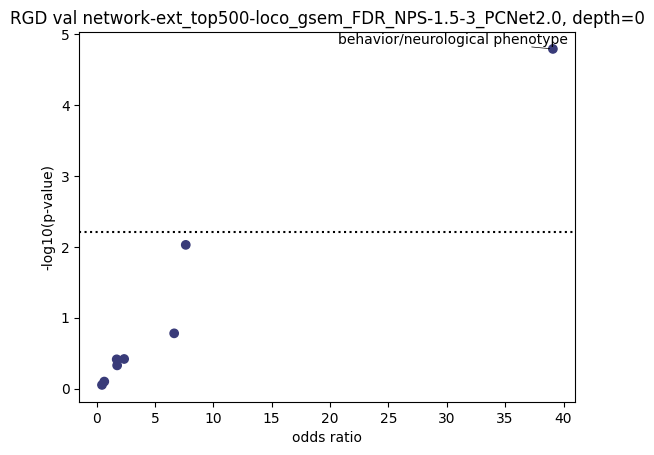

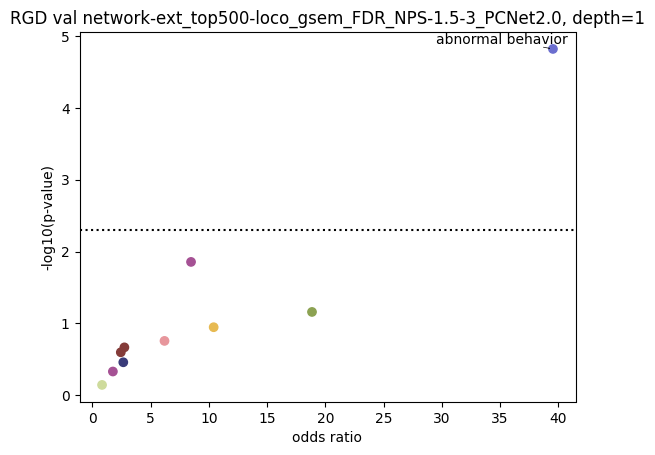

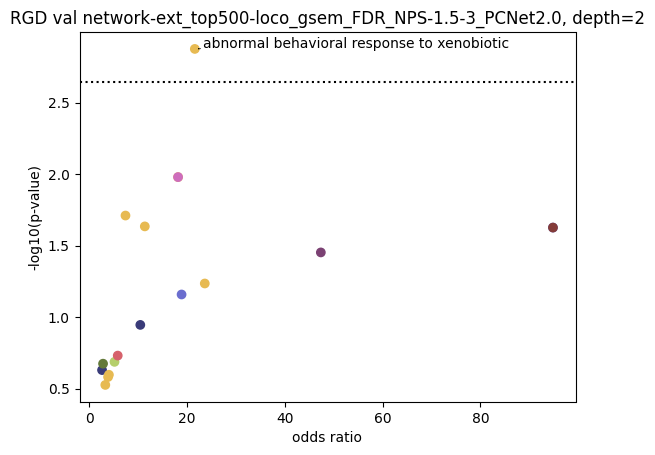

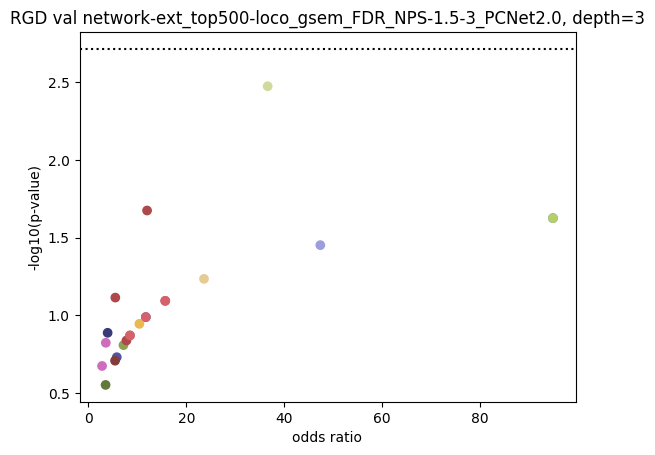

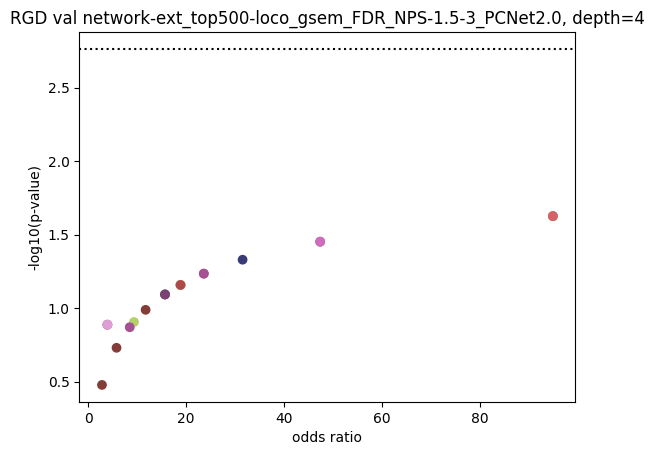

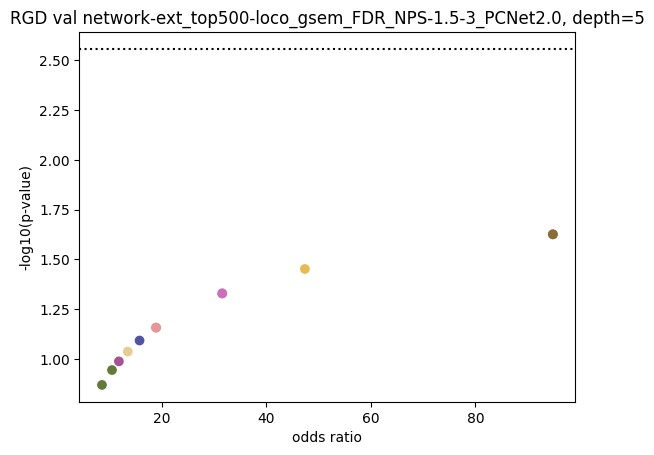

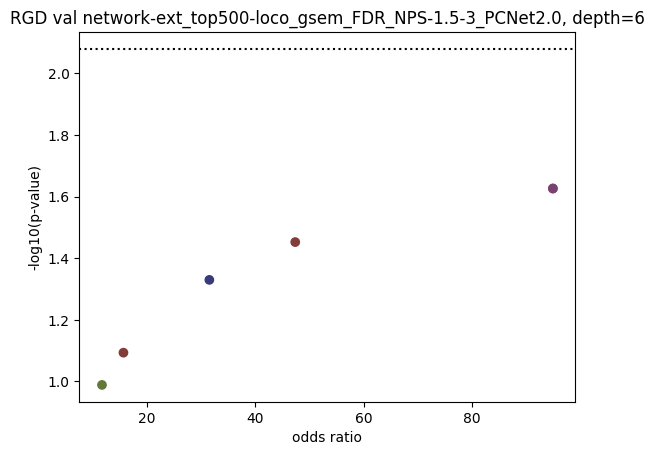

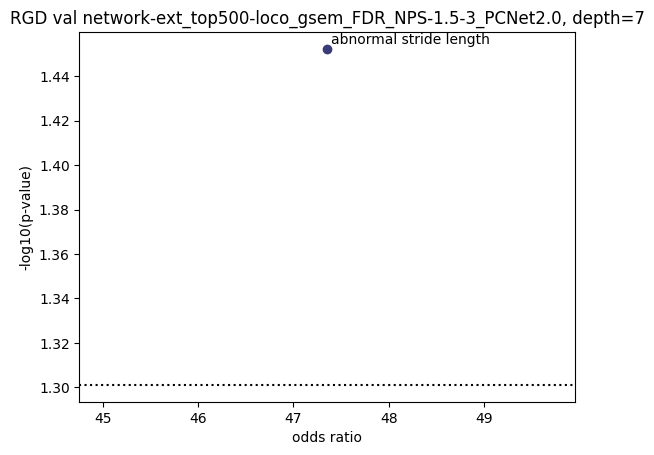

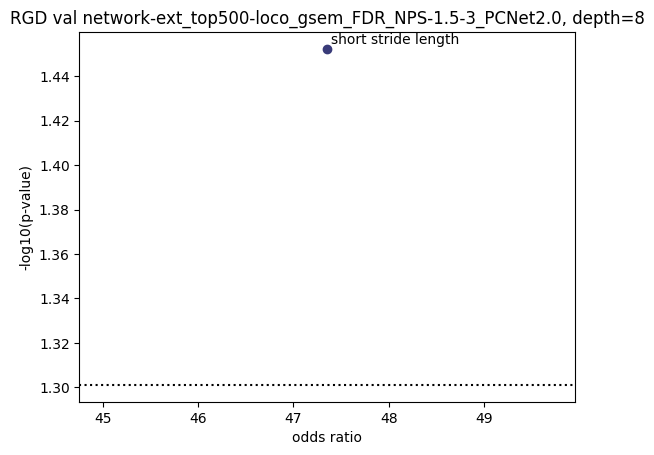

In [74]:
for d in set(tbl.depth):
    t=tbl[tbl.depth==d]
    unique_traits = t.parent_trait.unique()
    color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
    colors = [color_mapping[trait] for trait in t.parent_trait]  # Color assignment based on parent_trait

    plt.scatter(x=t.odds_ratio,y=-np.log10(t.p_intersect),color=colors)

    plt.xlabel('odds ratio')
    plt.ylabel('-log10(p-value)')
    plt.axhline(-np.log10(0.05/len(t)),color='black',ls=':',label='bonferroni')
    plt.title(f'RGD val {val_lab_dict[sub_community]}, depth={d}')
    texts = []
    for i in t.index:
        if (t.p_intersect[i]<(0.05/len(t))):
            texts.append(plt.annotate(t.trait[i], (t.odds_ratio[i], -np.log10(t.p_intersect[i]))))
    
    # Adjust text to avoid overlap
    adjust_text(texts, only_move={'points': 'y', 'texts': 'y'}, 
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    
    '''
    legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]
    plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
    '''
    if save_fig:
        if not filter_traits:
            plt.savefig((f'{outpath_dir}/RGD_val_scatter_depth-{d}.svg'), bbox_inches = "tight")
        else:
            plt.savefig((f'{outpath_dir}/RGD_val_filtered_scatter_depth-{d}.svg'), bbox_inches = "tight")

    plt.show()

## barplot

In [59]:
for d in range(0, max(tbl.depth)+1):
    t = tbl[tbl['depth'] == d]
    t=t[t['p_intersect']<0.05/len(t)]
    if (len(t)>0):
        t=t.sort_values('parent_trait',ascending=True)
        # Assign a unique color for each parent_trait based on its index
        unique_traits = t.parent_trait.unique()
        color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
        
        # Plotting
        fig = plt.figure(figsize=(10, 8))
        colors = [color_mapping[trait] for trait in t.parent_trait]  # Color assignment based on parent_trait
        
        plt.barh(y=t.trait, width=-np.log10(t.p_intersect*len(t)),label=t.parent_trait, color=colors)
        
        plt.ylabel('mammalian phenotype')
        plt.xlabel('corrected -log10(p-value)')
        plt.axvline(-np.log10(0.05), color='black', ls=':')
        plt.axvline(0, color='black', ls='-')
    
        #plt.xticks(rotation=90)
        #plt.title(d)
        plt.title(f'RGD val {val_lab_dict[sub_community]}, depth={d}')
        # Create legend patches (only one for each unique parent_trait)
        legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]
        
        # Add legend to the plot
        plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
        plt.tight_layout()
        plt.margins(y=0)
        # Show the plot
        if save_fig:
            if not filter_traits:
                plt.savefig((f'{outpath_dir}/RGD_val_bar_depth-{d}.svg'), bbox_inches = "tight")
            else:
                plt.savefig((f'{outpath_dir}/RGD_val_filtered_bar_depth-{d}.svg'), bbox_inches = "tight")
        plt.show()
        
        # Clear the figure after showing
        plt.clf()

AttributeError: 'DataFrame' object has no attribute 'depth'